In [3]:
from firedrake import *
from firedrake.petsc import PETSc
import os
from firedrake.__future__ import interpolate
from firedrake.output import VTKFile

printpar = PETSc.Sys.Print        # print once even in parallel

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [4]:
def generate_mesh(xt,yt, xb, yb):
    
    # generate a geo file and mesh for a surface given by (xt,yt) and a bottom given by (xb, yb)
    # xb should run backwards
    
    fd = open('channel.geo', 'w', newline="")
    fd.write('lc = 25;\n')
    Np = len(xt)
    
    for k in range(Np):
       line = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc};\n'
       fd.write(line)

    Nb = len(xb)
    for k in range(Nb):
       line = 'Point(' + str(k+Np+1) + ') = {' + str(xb[k]) + ',' + str(yb[k]) + ',0,lc};\n'
       fd.write(line)
    
    line = 'Line(1050) = {'
    for k in range(Np):
       line += str(k+1) + ','
    line = line[:-1] + '};\n'
    fd.write(line)
    
    fd.write('Line(1051) = {' + str(Np) + ',' + str(Np+1) + '};\n')
    
    line = 'Line(1052) = {'
    for k in range(Nb):
       line += str(Np+k+1) + ','
    line = line[:-1] + '};\n'
    fd.write(line)
    
    fd.write('Line(1053) = {' + str(Np+Nb) + ',1};\n')

    fd.write('Line Loop(1056) = {1050,1051,1052,1053};\n')
    
    fd.write('Plane Surface(1061) = {1056};\n')
    
    fd.write('Physical Line(1071) = {1050};\n') #surface
    fd.write('Physical Line(1072) = {1051};\n') #right side
    fd.write('Physical Line(1073) = {1052};\n') #bottom
    fd.write('Physical Line(1074) = {1053};\n') #left
    
    fd.write('Physical Surface(1081) = {1061};\n')   # if Physical Surface omitted, Gmsh fails
    
    fd.close()
    
    os.system('gmsh -2 -v 0 channel.geo')

In [5]:
xt = np.linspace(0,5000,201)
yt = 30*np.ones_like(xt)
xb = np.linspace(5000,0,201)
yb = -270*np.ones_like(xb)

generate_mesh(xt,yt,xb,yb)

In [6]:
secpera = 31556926.0    # seconds per year
g = 9.81                # m s-2
rho = 900.0             # kg m-3
rhow = 1000.0
n_glen = 3.0
A3 = 3.1689e-24         # Pa-3 s-1;  EISMINT I value of ice softness
B3 = A3**(-1.0/n_glen)     # Pa s(1/3);  ice hardness
Dtyp = 1.0 / secpera    # s-1

    
def D(w):               # strain-rate tensor
    return 0.5 * (grad(w) + grad(w).T)

fbody = Constant((0.0, - rho * g))

In [7]:
def melt(xb):
    return np.exp(-(xb-2500)**2/2500)

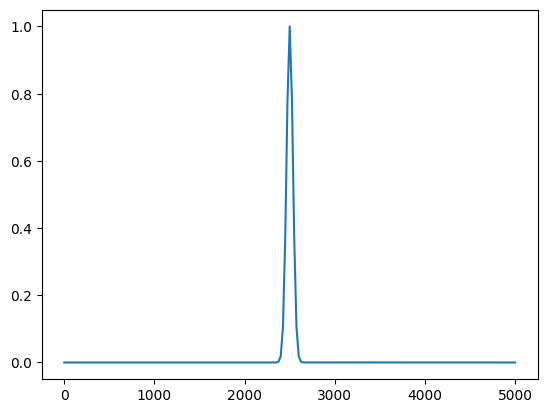

In [8]:
from matplotlib import pyplot as plt
plt.plot(xb,melt(xb))

In [9]:
t = 0.0

dt = .01
t_end = .5
    
myResults = VTKFile('channel.pvd')
while t<t_end:
    
    generate_mesh(xt,yt,xb,yb)

    printpar('reading mesh from channel.msh ...')
    mesh = Mesh('channel.msh')
    printpar('    (mesh with %d elements and %d vertices)' \
      % (mesh.num_cells(), mesh.num_vertices()))

    
    printpar = PETSc.Sys.Print        # print once even in parallel
    
    V = VectorFunctionSpace(mesh, 'Lagrange', 2)
    W = FunctionSpace(mesh, 'Lagrange', 1)
    Z = V * W
    
    up = Function(Z)
    u, p = split(up)
    v, q = TestFunctions(Z)
    
    # Get the coordinates of all the nodes in the quadratic space.
    x,y = SpatialCoordinate(mesh)
    
    eps = .01
    
    Du2 = 0.5 * inner(D(u), D(u)) + (eps * Dtyp)**2.0
    nu = 0.5 * B3 * Du2**((1.0 / n_glen - 1.0)/2.0)
 
    def wat_press(y):
        pw = rhow*g*y
        return pw
        
    #pw = Function(W).interpolate(rhow*g*y)
    pw = Function(W).interpolate(wat_press(y))
    n = FacetNormal(mesh)
    
    F = ( inner(2.0 * nu * D(u), D(v)) \
      - p * div(v) - q * div(u) - inner(fbody, v) ) * dx \
      - pw * inner(n,v) * ds(1073)
      
    bcs = [ DirichletBC(Z.sub(0), Constant((0.0, 0.0)), (1072,1074)) ]
    
    printpar('solving t = ' + str(t) + '....')
    par = {'snes_linesearch_type': 'bt',
       'ksp_type': 'preonly',
       'pc_type': 'lu',
       'pc_factor_shift_type': 'inblocks',
       'snes_max_it': 200}
#       'snes_atol': 1e2}

    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    eps /= 10
    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    
    eps /= 10
    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    
    eps /= 10
    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    
    # print average and maximum velocity
    P1 = FunctionSpace(mesh, 'CG', 1)
    one = Function(W).interpolate(1.0)
    area = assemble(dot(one,one) * dx)
    umagav = assemble(sqrt(dot(u, u)) * dx) / area
    umag = assemble(interpolate(sqrt(dot(u, u)), P1))
    with umag.dat.vec_ro as vumag:
        umagmax = vumag.max()[1]
    printpar('  ice speed (m a-1): av = %.3f, max = %.3f' \
         % (umagav * secpera, umagmax * secpera))

    if umagmax*secpera>100:
        dt = 0.001
    elif umagmax*secpera>10:
        dt = 0.0051
    elif umagmax*secpera<1:
        dt = 0.02
    else: 
        dt = 0.01
        
    printpar('saving to channel.pvd ...')
    u = up.subfunctions[0]
    p = up.subfunctions[1]
    P1 = FunctionSpace(mesh, 'CG', 1)
    Du = sqrt(0.5 * inner(D(u), D(u)))
    eff_strain = assemble(interpolate(Du*secpera, P1))
    eff_strain.rename('effective strain rate')
    u *= secpera    # save in m/a
    p /= 1.0e5      # save in bar
    u.rename('velocity (m/a)')
    p.rename('pressure (bar)')
    myResults.write(u, p, eff_strain, time=t)
    
    # updating the surface by remeshing
    bound_points = [[xt[i], yt[i]] for i in range(np.size(xt))]
    f = Function(V).interpolate(u)
    u_bound=f.at(bound_points)
    
    ux = np.array([u_bound[i][0] for i in range(len(u_bound))])
    uy = np.array([u_bound[i][1] for i in range(len(u_bound))])
    
    xt += ux*dt
    yt += uy*dt
    
    # updating the bottom by remeshing
    bottom_points = [[xb[i], yb[i]] for i in range(np.size(xb))]
    f = Function(V).interpolate(u)
    u_bottom=f.at(bottom_points)
    
    ux = np.array([u_bottom[i][0] for i in range(len(u_bottom))])
    uy = np.array([u_bottom[i][1] for i in range(len(u_bottom))])

    delx = -np.append(np.append(0,xb[2:]-xb[:-2]),0)
    dely = np.append(np.append(0,yb[2:]-yb[:-2]),0)
    nn = np.sqrt(delx**2+dely**2)
    nn[nn==0] = 1
    nx = -dely/nn
    ny = delx/nn
    m = 10*melt(xb)
    
    xb += ux*dt + m*nx*dt
    yb += uy*dt + m*ny*dt
    
    t += dt

reading mesh from channel.msh ...
    (mesh with 5606 elements and 3016 vertices)
solving t = 0.0....
  ice speed (m a-1): av = 0.000, max = 0.000
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 5610 elements and 3018 vertices)
solving t = 0.02....
  ice speed (m a-1): av = 0.282, max = 0.564
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 5616 elements and 3021 vertices)
solving t = 0.04....
  ice speed (m a-1): av = 2.907, max = 5.463
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 5742 elements and 3084 vertices)
solving t = 0.05....
  ice speed (m a-1): av = 15.140, max = 28.725
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 5676 elements and 3051 vertices)
solving t = 0.0551....
  ice speed (m a-1): av = 34.847, max = 65.708
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 5700 elements and 3063 vertices)
solving t = 0.060200000000000004....
  ice 

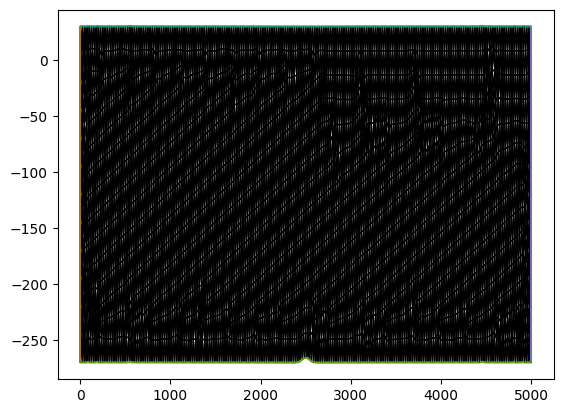

In [10]:
triplot(mesh)

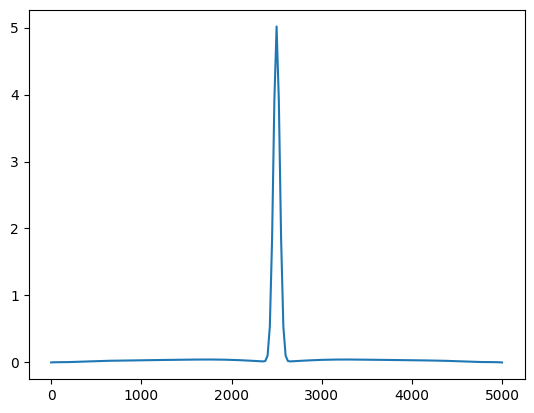

In [11]:
plt.plot(xb,yb+270)

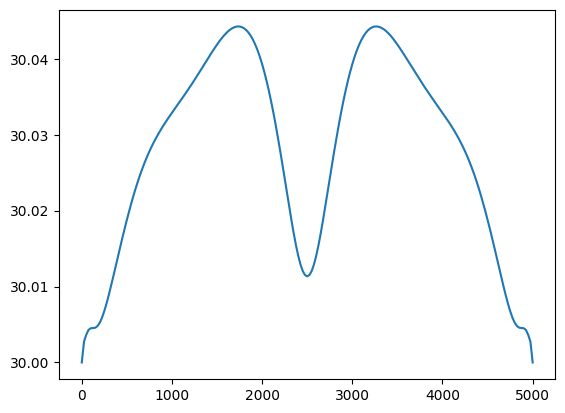

In [12]:
plt.plot(xt,yt)

In [ ]:
dx = -np.append(np.append(0,xb[2:]-xb[:-2]),0)
dy = np.append(np.append(0,yb[2:]-yb[:-2]),0)
n = np.sqrt(dx**2+dy**2)
n[n==0] = 1
nx = -dy/n
ny = dx/n

In [ ]:
dx